# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [11]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=83e95724-0ea3-47d1-b797-8738b4e71cf2
To: /content/HW2.zip
100% 52.1M/52.1M [00:02<00:00, 21.6MB/s]
replace data/test/5659.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#### Import packages

In [12]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torchsummary import summary
from torchvision import models
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [13]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 64,
    n_epoch = 20,
    lr = 2e-3,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [14]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

cuda


#### Dataset and Dataloader

In [15]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [16]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.ToTensor(),

])
eval_tfm = T.Compose([
    T.ToTensor(),
])

In [17]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)
image, label = next(iter(train_loader))
print(image.shape, label.shape)
print(image.min(), image.max())

torch.Size([64, 1, 64, 64]) torch.Size([64])
tensor(0.) tensor(1.)


#### Model

In [18]:
# TODO: define your CNN model
def FaceExpressionNet():
    x = models.resnet18()
    x.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    num_classes = 7  # adjust as needed
    x.fc = nn.Linear(x.fc.in_features, num_classes)
    return x

#### training loop

In [19]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

In [20]:
model = FaceExpressionNet().to(device)

summary(model, (1, 64, 64))
train(model, train_loader, valid_loader, config)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

100%|██████████| 362/362 [00:21<00:00, 17.15it/s]


Epoch: 1/20, train loss: 1.5891, train acc: 0.3796
Epoch: 1/20, valid loss: 1.4899, valid acc: 0.4003
== best valid acc: 0.4003 ==


100%|██████████| 362/362 [00:21<00:00, 16.47it/s]


Epoch: 2/20, train loss: 1.3557, train acc: 0.4803
Epoch: 2/20, valid loss: 1.4102, valid acc: 0.4516
== best valid acc: 0.4516 ==


100%|██████████| 362/362 [00:20<00:00, 17.33it/s]


Epoch: 3/20, train loss: 1.2707, train acc: 0.5165
Epoch: 3/20, valid loss: 1.2752, valid acc: 0.5041
== best valid acc: 0.5041 ==


100%|██████████| 362/362 [00:20<00:00, 17.35it/s]


Epoch: 4/20, train loss: 1.2057, train acc: 0.5433
Epoch: 4/20, valid loss: 1.2064, valid acc: 0.5339
== best valid acc: 0.5339 ==


100%|██████████| 362/362 [00:20<00:00, 17.30it/s]


Epoch: 5/20, train loss: 1.1573, train acc: 0.5630
Epoch: 5/20, valid loss: 1.1720, valid acc: 0.5584
== best valid acc: 0.5584 ==


100%|██████████| 362/362 [00:20<00:00, 17.40it/s]


Epoch: 6/20, train loss: 1.1216, train acc: 0.5721
Epoch: 6/20, valid loss: 1.1818, valid acc: 0.5518


100%|██████████| 362/362 [00:20<00:00, 17.40it/s]


Epoch: 7/20, train loss: 1.0917, train acc: 0.5901
Epoch: 7/20, valid loss: 1.1923, valid acc: 0.5399


100%|██████████| 362/362 [00:20<00:00, 17.38it/s]


Epoch: 8/20, train loss: 1.0647, train acc: 0.5969
Epoch: 8/20, valid loss: 1.0964, valid acc: 0.5819
== best valid acc: 0.5819 ==


100%|██████████| 362/362 [00:20<00:00, 17.42it/s]


Epoch: 9/20, train loss: 1.0405, train acc: 0.6051
Epoch: 9/20, valid loss: 1.1583, valid acc: 0.5530


100%|██████████| 362/362 [00:20<00:00, 17.40it/s]


Epoch: 10/20, train loss: 1.0124, train acc: 0.6218
Epoch: 10/20, valid loss: 1.0839, valid acc: 0.5894
== best valid acc: 0.5894 ==


100%|██████████| 362/362 [00:20<00:00, 17.52it/s]


Epoch: 11/20, train loss: 0.9886, train acc: 0.6306
Epoch: 11/20, valid loss: 1.0791, valid acc: 0.5882


100%|██████████| 362/362 [00:20<00:00, 17.51it/s]


Epoch: 12/20, train loss: 0.9687, train acc: 0.6338
Epoch: 12/20, valid loss: 1.0862, valid acc: 0.5885


100%|██████████| 362/362 [00:20<00:00, 17.53it/s]


Epoch: 13/20, train loss: 0.9507, train acc: 0.6411
Epoch: 13/20, valid loss: 1.0577, valid acc: 0.5938
== best valid acc: 0.5938 ==


100%|██████████| 362/362 [00:20<00:00, 17.62it/s]


Epoch: 14/20, train loss: 0.9315, train acc: 0.6514
Epoch: 14/20, valid loss: 1.0636, valid acc: 0.5975
== best valid acc: 0.5975 ==


100%|██████████| 362/362 [00:20<00:00, 17.65it/s]


Epoch: 15/20, train loss: 0.9017, train acc: 0.6631
Epoch: 15/20, valid loss: 1.1165, valid acc: 0.5851


100%|██████████| 362/362 [00:20<00:00, 17.73it/s]


Epoch: 16/20, train loss: 0.8855, train acc: 0.6699
Epoch: 16/20, valid loss: 1.0820, valid acc: 0.5928


100%|██████████| 362/362 [00:20<00:00, 17.59it/s]


Epoch: 17/20, train loss: 0.8595, train acc: 0.6791
Epoch: 17/20, valid loss: 1.0938, valid acc: 0.5837


100%|██████████| 362/362 [00:20<00:00, 17.63it/s]


Epoch: 18/20, train loss: 0.8337, train acc: 0.6884
Epoch: 18/20, valid loss: 1.0805, valid acc: 0.5982
== best valid acc: 0.5982 ==


100%|██████████| 362/362 [00:20<00:00, 17.58it/s]


Epoch: 19/20, train loss: 0.8024, train acc: 0.7008
Epoch: 19/20, valid loss: 1.0973, valid acc: 0.5947


 62%|██████▏   | 223/362 [00:12<00:08, 17.32it/s]


KeyboardInterrupt: 

100%|██████████| 91/91 [00:03<00:00, 25.75it/s]


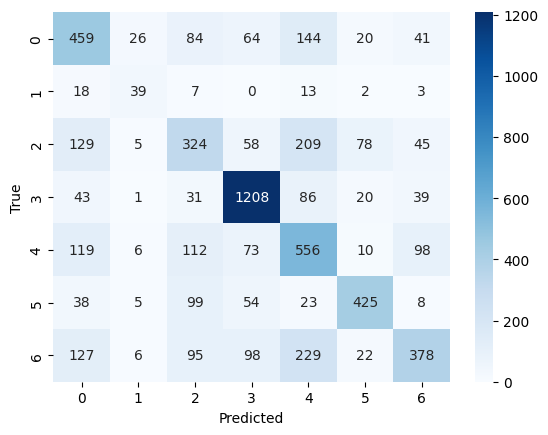

In [21]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

draw_confusion_matrix(model, valid_loader)


### Testing

In [22]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [23]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

100%|██████████| 110/110 [00:02<00:00, 36.68it/s]
